In [1]:
### used to plot all the signal/background distribution in the selection section, with individual mass/ctau points
### mostly for Nhits and dPhi plots in paper


import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

data_year = 'full'
lumi = {'MC_Summer16':35.9*1000,
        'MC_Fall17': 41.5*1000, 
        'MC_Fall18':  59.7*1000 ,
       
       }

ctau = '1000'
masses = ['7', '15','40','55']
ntupler_version = 'V1p17/'
analyzer_version = "/v1/v106/"
decay = 'dddd'
for m in masses:
    mc_path = '/storage/cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
    fpath[m] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+m+'_ctau-'+ctau+'_137000pb_weighted.root'
analyzer_version = "/v5/v100/"
data_path = '/storage/cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/'+analyzer_version+'/normalized/'
fpath['data'] = data_path +'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
NEvents = {}
for k,v in fpath.items():
    print (k, v)
   
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print("NEvents",NEvents[k])
    print(len(a))



7 /storage/cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v106//normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-1000_137000pb_weighted.root
NEvents 106227390.0
11588
15 /storage/cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v106//normalized/ggH_HToSSTodddd_MH-125_MS-15_ctau-1000_137000pb_weighted.root
NEvents 102585040.0
13086
40 /storage/cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v106//normalized/ggH_HToSSTodddd_MH-125_MS-40_ctau-1000_137000pb_weighted.root
NEvents 106752310.0
10683
55 /storage/cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v106//normalized/ggH_HToSSTodddd_MH-125_MS-55_ctau-1000_137000pb_weighted.root
NEvents 104310510.0
7604
data /storage/cms/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//Data2018//v5/v100//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-

# nCsc with different hit vetoing

In [3]:
%%time
r_denom = []
z_denom = []
r_nom = []
z_nom = []
weight_nom = []
weight_denom = []
llp_r = []
llp_z =[]
weight_llp = []


leading_jet = {}
time_spread = {}
mevetos = {}
me11 = {}
me12 = {}
me1112 = {}
re12 = {}
mb1 = {}
rb1 = {}
eta = {}
time = {}
cut_based_id = {}
weight_me11 = {}
weight_me12 = {}
weight_re12 = {}
weight_mb1 = {}
weight_rb1 = {}
weight_eta = {}
weight_time = {}
weight_time_spread = {}
weight_jet = {}
weight_me1112 = {}
cscRechitClusterEta = {}
cscRechitClusterNStation = {}
cscRechitClusterAvgStation = {}
dphiMet_cluster = {}
nCsc = {}
weight = {}

for k in masses+['data_intime','data_oot','data_unblind']:
# for k in masses+['data_unblind','data_oot'] + [m+'_oot' for m in masses]:
    print(k)
    
    
#     if 'data' in k:continue
    
    if 'data' in k: T = tree['data']
    elif '15' in k:T = tree['15']
    elif '40' in k:T = tree['40']
    elif '55' in k:T = tree['55']
    else: T = tree[k]
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )
    cluster_index = '3'
    ########### SELECTION: CLUSTERS ############
    if 'data' in k:
        sel_rechitcluster = np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.0
    else:
#         sel_rechitcluster = T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc')
        sel_rechitcluster = np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.0
    if 'oot' in k:
        
        sel = [T.array('cscRechitCluster'+cluster_index+'TimeTotal') < -12.5,]
    elif k == 'data_intime':
        sel = [np.logical_and(T.array('cscRechitCluster'+cluster_index+'Size') < 80,\
                              np.logical_and(T.array('cscRechitCluster'+cluster_index+'TimeTotal') > -5.0, T.array('cscRechitCluster'+cluster_index+'TimeTotal') < 12.5)),]
    else:
        sel = [np.logical_and(T.array('cscRechitCluster'+cluster_index+'TimeTotal') > -5.0, T.array('cscRechitCluster'+cluster_index+'TimeTotal') < 12.5),]
    sel+=[
        T.array('cscRechitCluster'+cluster_index+'JetVetoPt') < 10,
        T.array('cscRechitCluster'+cluster_index+'MuonVetoPt') < 20,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11') <= 0,
         T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12') <= 0,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11') <= 0,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12') <= 0,
        T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= 0,
        T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4') <= 0,
        T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4') <= 0,
        np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.0,
         T.array('cscRechitCluster'+cluster_index+'TimeSpread') < 20,
    ]
    for ele in sel:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, ele)
#     sel_rechitcluster = sel_rechitcluster&sel[0]&sel[1]&sel[2]&sel[3]&sel[4]&sel[5]&sel[6]&sel[7]&sel[8]&sel[9]&sel[10]&sel[11]
    
    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    if 'data' in k:
        sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) >= 0
    else:
        sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) >= 0
    sel_ev   = np.logical_and(sel_ev ,T.array('METNoMuTrigger'))
    sel_ev = np.logical_and(sel_ev ,T.array('metEENoise') > 200)
    sel_ev  = np.logical_and(sel_ev, T.array('category') == 0)
    sel_ev = np.logical_and(sel_ev ,T.array('nLeptons') == 0)
    sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
    sel_ev = np.logical_and(sel_ev, (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)


    cscRechitClusterEta[k] =  T.array('cscRechitCluster'+cluster_index+'Eta')[sel_rechitcluster][sel_ev]
    cscRechitClusterNStation[k] =  T.array('cscRechitCluster'+cluster_index+'NStation10')[sel_rechitcluster][sel_ev]
    cscRechitClusterAvgStation[k] =  T.array('cscRechitCluster'+cluster_index+'AvgStation10')[sel_rechitcluster][sel_ev]
    
    
    cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
    cond1 = np.logical_and(cscRechitClusterNStation[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation[k])==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(cscRechitClusterNStation[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
    cut_based_id[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
                
    nCsc[k] =  T.array('cscRechitCluster'+cluster_index+'Size')[sel_rechitcluster][sel_ev]
    dphiMet_cluster[k] =  T.array('cscRechitCluster'+cluster_index+'MetEENoise_dPhi')[sel_rechitcluster][sel_ev]
        
    if not 'data' in k:weight[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+cscRechitClusterEta[k]*0.0
    else: weight[k] = cscRechitClusterEta[k]*0.0 +1.0
        
    

7
15
40
55
data_intime
data_oot
data_unblind
CPU times: user 4min 39s, sys: 1min 36s, total: 6min 16s
Wall time: 13min 30s


# Plots (2bin)

7 18.270844521236924
15 25.70944618483167
40 18.05958166079317
55 6.793436807147511
data_unblind 50.0
bkg 50.0
bkg_err 50.0
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//unblind//Nrechits_2bin_dddd_paper.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//unblind//Nrechits_2bin_dddd_paper.C has been generated
Info in <TCanvas::Print>:

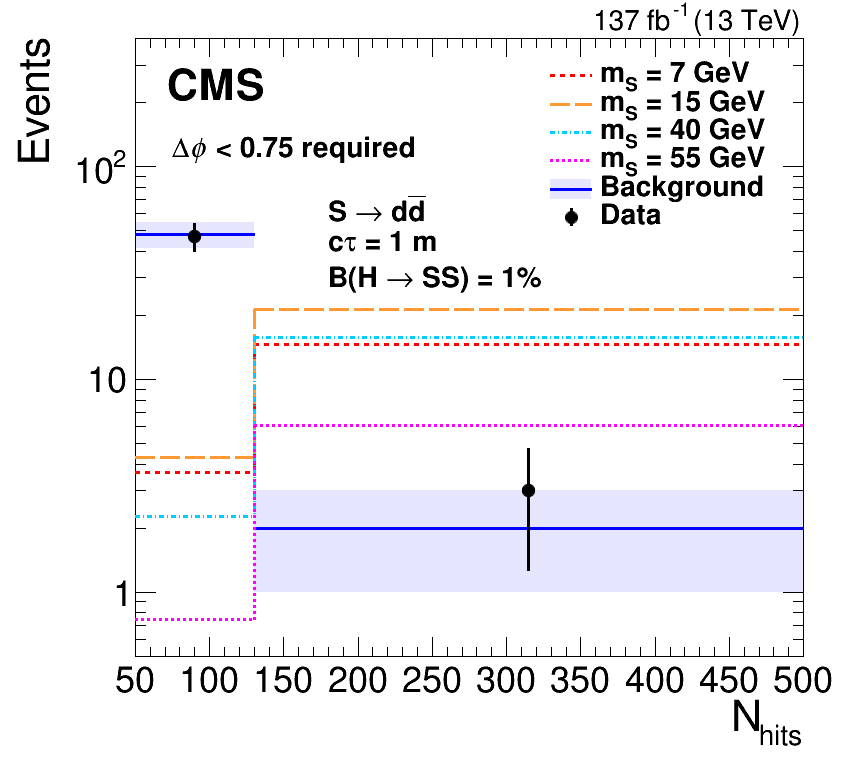

In [13]:
import os
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle

corrections = 0.90332048232



index = 0
if index == 1:cut_index = 0
elif index == 0:cut_index = 1
with_background = 1
paper = 1
unblind = 1
nrechit_cut = 130
dphi_cut = 0.75


var = [nCsc, dphiMet_cluster]
weights = [weight, weight ]
xaxis = [ 'N_{hits}', '#Delta#it{#phi}(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster) [radians]']


name = ['Nrechits','dphi_cluster_met']
ymax = 500
binning = [[50,130,ymax],[0,0.75,3.14]]


if index == 0: leg = rt.TLegend(0.64,0.70,0.92,0.92)
else: leg = rt.TLegend(0.60,0.70,0.90,0.92)
leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(masses):
    overflow = np.abs(var[index][k][cut_based_id[k]].flatten())
    if index == 0: overflow[overflow>=ymax]=ymax-1
    if cut_index == 0: h[k] = create_TH1D(overflow[var[cut_index][k][cut_based_id[k]].flatten()>=nrechit_cut],  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], var[cut_index][k]>=nrechit_cut)].flatten(), bin_list = True)
    else: h[k] = create_TH1D(overflow[np.abs(var[cut_index][k][cut_based_id[k]].flatten())<dphi_cut],  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], np.abs(var[cut_index][k])<dphi_cut)].flatten(), bin_list = True)
    if i == 1:h[k].SetLineColor(801)
#     elif i == 2:h[k].SetLineColor(819)
    elif i == 2:h[k].SetLineColor(870)

    else:h[k].SetLineColor(std_color_list[i+1])
    h[k].Scale(corrections)    
    leg.AddEntry(h[k],"m_{S} = "+k+" GeV",'L')


if cut_index == 0:h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cut_based_id['data_unblind'], var[cut_index]['data_unblind']>=nrechit_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index], bin_list = True)

else:h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cut_based_id['data_unblind'], np.abs(var[cut_index]['data_unblind'])<dphi_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index], bin_list = True)

    

    
if index == 0:
    bkg = [55, 150]
    w = [48.0, 2.0]
    h['bkg'] = create_TH1D(bkg,  axis_title=[xaxis[index], 'Events'], binning = binning[index], weights = w, bin_list = True)
    h['bkg'].SetBinError(1, 6.6)
    h['bkg'].SetBinError(2,1.0) #SR
else:#dphi
    bkg = [0.05, 1]
    w = [2.0, 4.0]
    h['bkg'] = create_TH1D(np.array(bkg),  axis_title=[xaxis[index], 'Events'], binning = binning[index], weights = np.array(w), bin_list = True)


    h['bkg'].SetBinError(1,1.0) #SR
    h['bkg'].SetBinError(2, 1.9)
h['bkg'].SetLineWidth(3)
h['bkg'].SetLineColor(4)

h['bkg_err'] = h['bkg'].Clone()


leg.AddEntry(h['bkg_err'], 'Background')


h['data_unblind'].SetLineWidth(3)


h['data_unblind'].SetLineColor(1)
h['data_unblind'].SetMarkerStyle(20)
h['data_unblind'].SetMarkerSize(1.5)
h['data_unblind'].GetYaxis().SetRangeUser(0.5,400)
if index == 1: h['data_unblind'].GetXaxis().SetTitleOffset(0.99)


leg.AddEntry(h['data_unblind'], 'Data','EP')
h['data_unblind'].Draw('esamex0')

h['bkg_err'].SetLineWidth(3)

h['bkg_err'].SetLineColor(4)
# h['bkg_err'].SetFillStyle(3002)
h['bkg_err'].SetFillColorAlpha(4,0.1)

h['bkg_err'].Draw('l E2 same')
h['bkg'].SetBinError(1, 0.001)
h['bkg'].SetBinError(2,0.001) #SR
h['bkg'].Draw('L same')






for k in masses:

    h[k].SetLineWidth(3)
    
    h[k].SetLineStyle(9)
    if k== '7':h[k].SetLineStyle(7)
    elif k== '15':h[k].SetLineStyle(9)
    elif k== '40':h[k].SetLineStyle(5)
    elif k== '55':h[k].SetLineStyle(2)




    h[k].Draw(' hist same')
for k,v in h.items():print(k, v.Integral())
h['data_unblind'].Draw('esamex0')


latex = rt.TLatex()
latex.SetTextSize(0.05)
latex.SetTextFont(42)

latex = rt.TLatex()
latex.SetTextSize(0.04)
if index == 1:
    x = 1.8
    if decay == 'dddd': latex.DrawLatex(x,24,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(x,24, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(x,24, "S #rightarrow #tau^{+}#tau^{-}")
    latex.DrawLatex(x,17.5, "c#tau = 1 m")
    latex.DrawLatex(x,12, "B(H #rightarrow SS) = 1%")
    latex.DrawLatex(0.18, 90,'N_{hits} #geq 130 required')



else:
    x = 180
    latex.DrawLatex(75,110, '#Delta#it{#phi} < 0.75 required')
    latex.DrawLatex(x,27, "B(H #rightarrow SS) = 1%")
    latex.DrawLatex(x,40, "c#tau = 1 m")

    if decay == 'dddd': latex.DrawLatex(x,55,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(x,55, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(x,55, "S #rightarrow #tau^{+}#tau^{-}")

        
# l.SetLineWidth(2)
# l.Draw()    


c.SetRightMargin(0.05)
c.SetBottomMargin(0.15)



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
CMS_lumi.writeExtraText = 0
CMS_lumi.extraText   = "Preliminary"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.12
CMS_lumi.relPosY = 0.05
CMS_lumi.cmsTextSize      = 1.2


CMS_lumi.CMS_lumi(c, 4, 11)

c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()
outDir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version
if unblind:outDir += '/unblind/'
if not os.path.isdir(outDir):os.makedirs(outDir)

if CMS_lumi.writeExtraText:
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_pas_paper.png')
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_pas_paper.C')
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_pas_paper.pdf')
else:
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_paper.png')
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_paper.C')
    c.SaveAs(outDir+'/'+name[index]+'_2bin_'+decay+'_paper.pdf')

# Plots (paper version)

7 17.941014845579563
15 23.98642550246696
40 15.858852504022602
55 6.053299819905402
data_unblind 6.0
data_intime 0.0
data_oot 7.0
137 fb^{-1} (13 TeV)
here 0.25479999676346776


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//unblind//dphi_cluster_met_dddd_pas_paper.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//

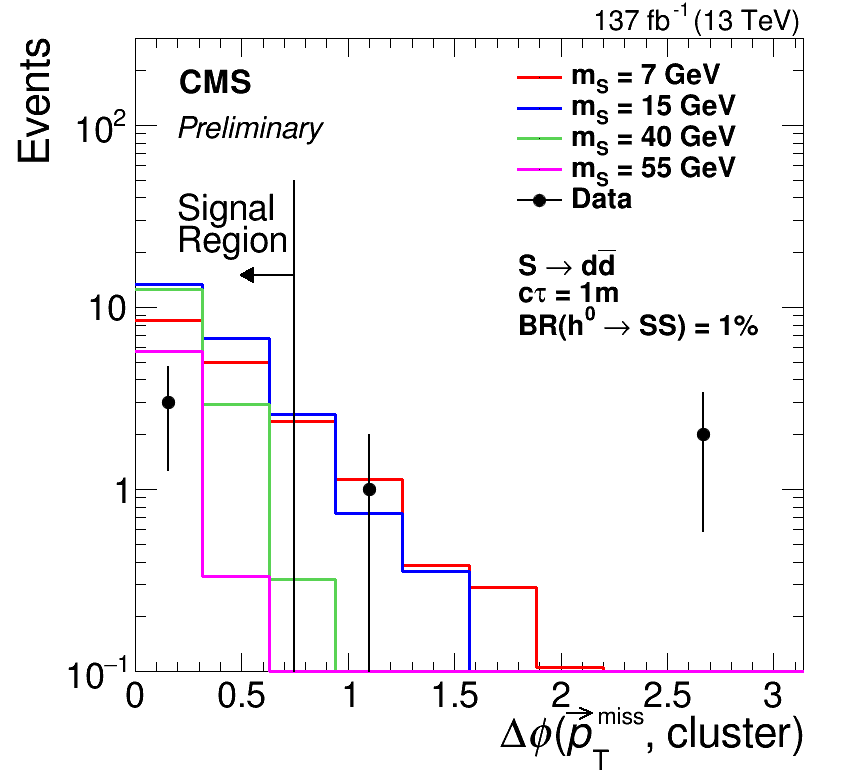

In [37]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])
# from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle

corrections = 0.90332048232



index = 8
if index == 8:cut_index = 7
elif index == 7:cut_index = 8
with_background = 1
paper = 1
unblind = 1
nrechit_cut = 130
dphi_cut = 0.75



var = [leading_jet, me1112,re12,rb1,mb1,eta,time_spread, nCsc, dphiMet_cluster]
weights = [weight_jet, weight_me1112,weight_re12,weight_rb1,weight_mb1,weight_eta,weight_time_spread,weight, weight ]
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#phi(p_{T}^{miss}, cluster)']
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#it{#phi}(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster)']


name = ['leading_jet','me1112','re12','rb1','mb1','eta','time_spread','Nrechits','dphi_cluster_met']
ymax = 1090
# binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],[25,50,ymax],[10,0,3.14]]
binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],list(np.arange(50,1050+80,80)),[10,0,3.14]]


if not unblind: 
    leg = rt.TLegend(0.5,0.72,0.78,0.92)
    leg.SetTextSize(0.035)
else:
    leg = rt.TLegend(0.60,0.72,0.90,0.92)
    leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(masses):
    overflow = np.abs(var[index][k][cut_based_id[k]].flatten())
    if index == 7: overflow[overflow>=ymax]=ymax-1
    if cut_index == 7: h[k] = create_TH1D(overflow[var[cut_index][k][cut_based_id[k]].flatten()>=nrechit_cut],  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], var[cut_index][k]>=nrechit_cut)].flatten())
    else: h[k] = create_TH1D(overflow[np.abs(var[cut_index][k][cut_based_id[k]].flatten())<dphi_cut],  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], np.abs(var[cut_index][k])<dphi_cut)].flatten())
    h[k].SetLineColor(std_color_list[i+1])
    h[k].Scale(corrections)
    if index == 7: h[k].GetXaxis().SetNdivisions(5,5,0,False)
    h[k].SetLineWidth(3)
    
    leg.AddEntry(h[k],"m_{S} = "+k+" GeV")



# h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][cut_based_id['data_unblind']].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
# h['data_intime'] = create_TH1D(np.abs(var[index]['data_intime'][cut_based_id['data_intime']].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
# h['data_oot'] = create_TH1D(np.abs(var[index]['data_oot'][cut_based_id['data_oot']].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
# 
if cut_index == 7:h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cut_based_id['data_unblind'], var[cut_index]['data_unblind']>=nrechit_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])

else:h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cut_based_id['data_unblind'], np.abs(var[cut_index]['data_unblind'])<dphi_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = [26,50,ymax])

h['data_intime'] = create_TH1D(np.abs(var[index]['data_intime'][np.logical_and(cut_based_id['data_intime'], nCsc['data_intime']>=nrechit_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
h['data_oot'] = create_TH1D(np.abs(var[index]['data_oot'][np.logical_and(cut_based_id['data_oot'], nCsc['data_oot']>=nrechit_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])





h['data_unblind'].SetLineColor(1)
h['data_unblind'].SetMarkerStyle(20)
h['data_unblind'].SetMarkerSize(1.5)
h['data_unblind'].GetYaxis().SetRangeUser(0.1,300)
leg.AddEntry(h['data_unblind'], 'Data')
h['data_unblind'].Draw('esamex0')


# if index == 7:
#     h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 2*max(map(lambda x: x.GetMaximum(), list(h.values()))))
# else:
# #     h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), max(map(lambda x: x.GetMaximum(), list(h.values()))))
#     h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 0.01*max(map(lambda x: x.GetMaximum(), list(h.values()))))


for k in masses:h[k].Draw(' hist same')
for k,v in h.items():print(k, v.Integral())
if unblind: h['data_unblind'].Draw('esamex0')
else:h['data_intime'].Draw('esamex0')

latex = rt.TLatex()
latex.SetTextSize(0.05)
latex.SetTextFont(42)
if index == 7:
    arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"|>")
    l = rt.TLine(130,0, 130, 50)
    arrow.SetLineWidth(2)        
    arrow.DrawArrow(130,20,200,20)
    latex.DrawLatex(150,8, "Signal Region")
else:
    arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
    l = rt.TLine(0.75,0, 0.75, 50)
    arrow.SetLineWidth(2)        
    arrow.DrawArrow(0.5,15,0.75,15)
    latex.DrawLatex(0.2,30, "Signal")
    latex.DrawLatex(0.2,20, "Region")

latex = rt.TLatex()
latex.SetTextSize(0.04)
if index == 8:
    x = 1.8
    if decay == 'dddd': latex.DrawLatex(x,15,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(x,15, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(x,15, "S #rightarrow #tau^{+}#tau^{-}")
    latex.DrawLatex(x,10.6, "c#tau = 1m")
    latex.DrawLatex(x,7, "BR(h^{0} #rightarrow SS) = 1%")


elif index == 7:
#     latex.DrawLatex(650,5, "c#tau = 1m")
#     latex.DrawLatex(650,3, "BR(h^{0} #rightarrow SS) = 1%")
#     if decay == 'dddd': latex.DrawLatex(650,8,  "S #rightarrow d#bar{d}")
#     elif decay == 'bbbb': latex.DrawLatex(650,8, "S #rightarrow b#bar{b}")
#     elif decay == '4Tau': latex.DrawLatex(650,8, "S #rightarrow #tau^{+}#tau^{-}")
    latex.DrawLatex(650,10.6, "c#tau = 1m")
    latex.DrawLatex(650,7, "BR(h^{0} #rightarrow SS) = 1%")
    if decay == 'dddd': latex.DrawLatex(650,15,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(650,15, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(650,15, "S #rightarrow #tau^{+}#tau^{-}")

l.SetLineWidth(2)
l.Draw()    


c.SetRightMargin(0.05)


tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Preliminary"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.12
CMS_lumi.relPosY = 0.05

CMS_lumi.CMS_lumi(c, 4, 11)

c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()
outDir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version
if unblind:outDir += '/unblind/'
if not os.path.isdir(outDir):os.makedirs(outDir)
if not paper:
    if with_background:
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'.png')
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'.C')
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'.pdf')

    else:
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_sig.png')
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_sig.C')
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_sig.pdf')


else:
    if CMS_lumi.writeExtraText:
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_pas_paper.png')
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_pas_paper.C')
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_pas_paper.pdf')
    else:
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_paper.png')
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_paper.C')
        c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_paper.pdf')

# Plots with anti-cuts

7 18.27084452123692
15 25.70944618483167
40 18.059581660793167
55 6.793436807147511
data_unblind 50.0
invert 99.0
137 fb^{-1} (13 TeV)
here 0.25479999676346776


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//unblind//Nrechits_dddd_aux_inverted_Preliminary.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficienci

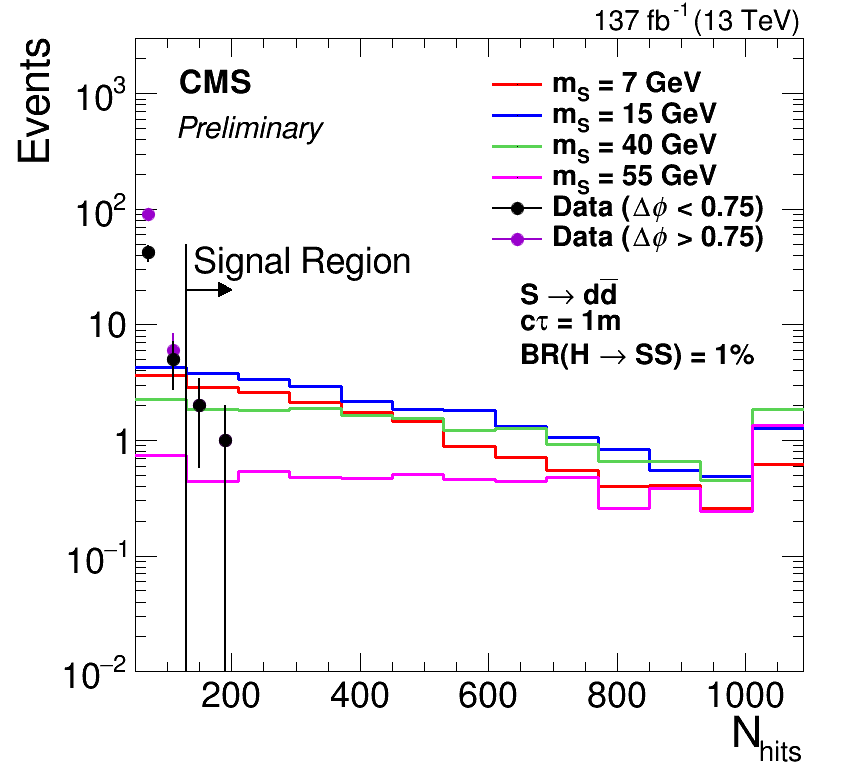

In [12]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])
# from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle

corrections = 0.90332048232



index = 7
if index == 8:cut_index = 7
elif index == 7:cut_index = 8
with_background = 1
paper = 1
unblind = 1
nrechit_cut = 130
dphi_cut = 0.75



var = [leading_jet, me1112,re12,rb1,mb1,eta,time_spread, nCsc, dphiMet_cluster]
weights = [weight_jet, weight_me1112,weight_re12,weight_rb1,weight_mb1,weight_eta,weight_time_spread,weight, weight ]
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#phi(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster)']
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#it{#phi}(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster)']


name = ['leading_jet','me1112','re12','rb1','mb1','eta','time_spread','Nrechits','dphi_cluster_met']
ymax = 1090
# binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],[25,50,ymax],[10,0,3.14]]
binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],list(np.arange(50,1050+80,80)),[10,0,3.14]]



leg = rt.TLegend(0.57,0.67,0.90,0.91)
leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(masses):
    
    overflow = np.abs(var[index][k][cut_based_id[k]].flatten())
    if index == 7: overflow[overflow>=ymax]=ymax-1
    if cut_index == 7: h[k] = create_TH1D(overflow[var[cut_index][k][cut_based_id[k]].flatten()>=nrechit_cut],  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], var[cut_index][k]>=nrechit_cut)].flatten())
    else: h[k] = create_TH1D(overflow[np.abs(var[cut_index][k][cut_based_id[k]].flatten())<dphi_cut],  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], np.abs(var[cut_index][k])<dphi_cut)].flatten())
    h[k].SetLineColor(std_color_list[i+1])
    h[k].Scale(corrections)
    if index == 7: h[k].GetXaxis().SetNdivisions(5,5,0,False)
    h[k].SetLineWidth(3)
    h[k].SetLabelFont(22)
    leg.AddEntry(h[k],"m_{S} = "+k+" GeV")



if cut_index == 7:
    h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cut_based_id['data_unblind'], var[cut_index]['data_unblind']>=nrechit_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
    h['invert'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cut_based_id['data_unblind'], var[cut_index]['data_unblind']<nrechit_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])


else:
    h['data_unblind'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cut_based_id['data_unblind'], np.abs(var[cut_index]['data_unblind'])<dphi_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = [26,50,ymax])
    h['invert'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cut_based_id['data_unblind'], np.abs(var[cut_index]['data_unblind'])>=dphi_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = [26,50,ymax])





h['data_unblind'].SetLineColor(1)
h['data_unblind'].SetMarkerStyle(20)
h['data_unblind'].SetMarkerSize(1.5)
# h['data_unblind'].GetXaxis().SetLabelSize(0.04)
# h['data_unblind'].GetYaxis().SetRangeUser(0.1,800)
h['data_unblind'].GetYaxis().SetRangeUser(0.01,3000)
# h['data_unblind'].SetLabelFont(102)





if index == 7:
    leg.AddEntry(h['data_unblind'], 'Data (#Delta#it{#phi} < 0.75)')
    leg.AddEntry(h['invert'], 'Data (#Delta#it{#phi} > 0.75)')
else:
    leg.AddEntry(h['data_unblind'], 'Data (N_{hits} > 130)')
    leg.AddEntry(h['invert'], 'Data (N_{hits} < 130)')
h['data_unblind'].Draw('esamex0')

color = 879
h['invert'].SetLineColor(color)
h['invert'].SetMarkerColor(color)
h['invert'].SetLabelFont(22)




h['invert'].SetMarkerStyle(20)
h['invert'].SetMarkerSize(1.5)



temp = h['invert'].Clone()
# temp.Draw('hist same')

# h['invert'].SetFillStyle(3002)
# h['invert'].SetFillColor(h['invert'].GetLineColor())
# h['invert'].SetLineColor(h['invert'].GetLineColor())
h['invert'].Draw('esamex0')





for k in masses:h[k].Draw(' hist same')
for k,v in h.items():print(k, v.Integral())
h['data_unblind'].Draw('esamex0')

latex = rt.TLatex()
latex.SetTextSize(0.05)
latex.SetTextFont(42)
if index == 7:
    arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"|>")
    l = rt.TLine(130,0, 130, 50)
    arrow.SetLineWidth(2)        
    arrow.DrawArrow(130,20,200,20)
    latex.DrawLatex(140,28, "Signal Region")
else:
    arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
    l = rt.TLine(0.75,0, 0.75, 100)
    arrow.SetLineWidth(2)        
    arrow.DrawArrow(0.5,50,0.75,50)
    latex.DrawLatex(0.2,120, "Signal")
    latex.DrawLatex(0.2,60, "Region")

latex = rt.TLatex()
latex.SetTextSize(0.04)
 
if index == 8:
    x = 1.94
    if decay == 'dddd': latex.DrawLatex(x,0.46,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(x,0.6, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(x,0.6, "S #rightarrow #tau^{+}#tau^{-}")
    latex.DrawLatex(x,0.27, "c#tau = 1m")
    latex.DrawLatex(x,0.14, "BR(H #rightarrow SS) = 1%")


elif index == 7:
    latex.DrawLatex(650,9, "c#tau = 1m")
    latex.DrawLatex(650,4.5, "BR(H #rightarrow SS) = 1%")
    if decay == 'dddd': latex.DrawLatex(650,15,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(650,15, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(650,15, "S #rightarrow #tau^{+}#tau^{-}")
l.SetLineWidth(2)
l.Draw()    


c.SetRightMargin(0.05)


tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Preliminary"
# CMS_lumi.extraText   = "Supplementary"


CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.12
CMS_lumi.relPosY = 0.05
CMS_lumi.CMS_lumi(c, 4, 11)

c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()
outDir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version
if unblind:outDir += '/unblind/'
if not os.path.isdir(outDir):os.makedirs(outDir)
if CMS_lumi.writeExtraText:
    c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_inverted_'+CMS_lumi.extraText+'.png')
    c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_inverted_'+CMS_lumi.extraText+'.C')

    c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_inverted_'+CMS_lumi.extraText+'.pdf')
else:
    c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_inverted.png')
    c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_inverted.C')
    c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_inverted.pdf')


7 25.64519437312265
15 32.48976991084419
40 20.119406606333996
55 7.553683087257468


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


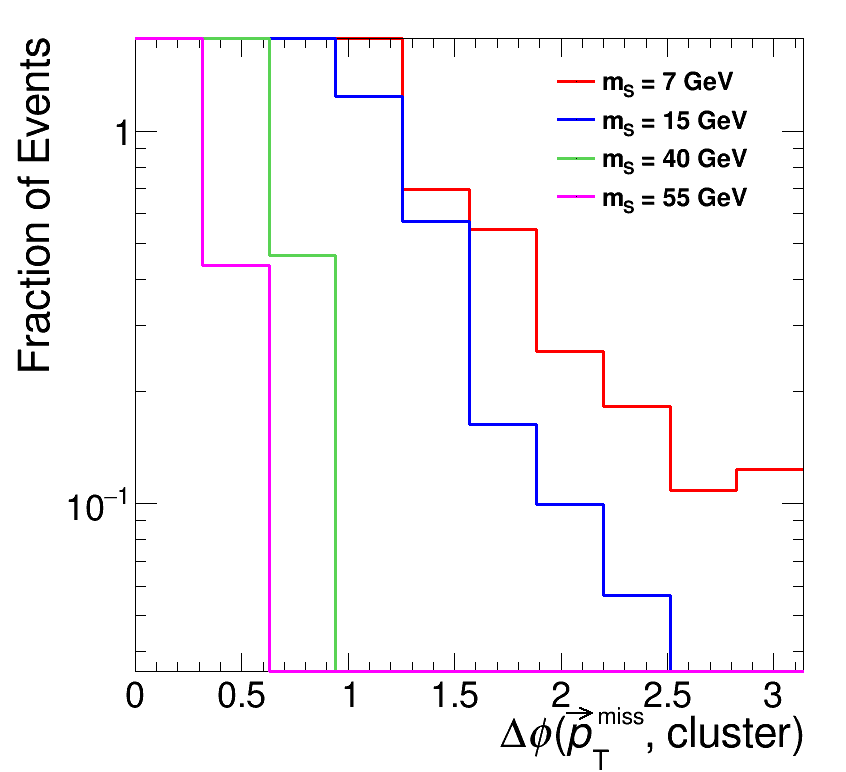

In [6]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])
# from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle

corrections = 0.90332048232



index = 8
if index == 8:cut_index = 7
elif index == 7:cut_index = 8
with_background = 1
paper = 1
unblind = 0
nrechit_cut = 0
dphi_cut = 5



var = [leading_jet, me1112,re12,rb1,mb1,eta,time_spread, nCsc, dphiMet_cluster]
weights = [weight_jet, weight_me1112,weight_re12,weight_rb1,weight_mb1,weight_eta,weight_time_spread,weight, weight ]
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#phi(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster)']
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#it{#phi}(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster)']


# ./utils/general/ptdr-definitions.sty:\newcommand{\ptvecmiss}{\ensuremath{{\vec p}_{\mathrm{T}}^{\kern1pt\text{miss}}}\xspace}

name = ['leading_jet','me1112','re12','rb1','mb1','eta','time_spread','Nrechits','dphi_cluster_met']
ymax = 2000
binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],[25,0,ymax],[10,0,3.14]]
# binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],list(np.arange(50,1050+80,80)),[10,0,3.14]]


# [30,0,3000]
if not unblind: 
    leg = rt.TLegend(0.65,0.72,0.90,0.92)
    leg.SetTextSize(0.035)
else:
    leg = rt.TLegend(0.65,0.72,0.90,0.92)
    leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(masses):
    overflow = np.abs(var[index][k][cut_based_id[k]].flatten())
    if index == 7: overflow[overflow>=ymax]=ymax-1
#     h[k] = create_TH1D(overflow,  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
#                        weights = 0.01*weights[index][k][cut_based_id[k]].flatten())
    if cut_index == 7: h[k] = create_TH1D(overflow[var[cut_index][k][cut_based_id[k]].flatten()>=nrechit_cut],  axis_title=[xaxis[index], 'Fraction of Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], var[cut_index][k]>=nrechit_cut)].flatten())
    else: h[k] = create_TH1D(overflow[np.abs(var[cut_index][k][cut_based_id[k]].flatten())<dphi_cut],  axis_title=[xaxis[index], 'Fraction of Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], np.abs(var[cut_index][k])<dphi_cut)].flatten())
    h[k].SetLineColor(std_color_list[i+1])
#     h[k].Scale(1./h[k].Integral())
    if index == 7: h[k].GetXaxis().SetNdivisions(5,5,0,False)
    h[k].SetLineWidth(3)
    leg.AddEntry(h[k],"m_{S} = "+k+" GeV")





if index == 7:
    h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 2*max(map(lambda x: x.GetMaximum(), list(h.values()))))
else:
#     h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), max(map(lambda x: x.GetMaximum(), list(h.values()))))
    h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 0.1*max(map(lambda x: x.GetMaximum(), list(h.values()))))


for k in masses:h[k].Draw(' hist same')
for k,v in h.items():print(k, v.Integral())

# if index == 8:
# #     xtitle = rt.TLatex(rt.gPad.GetUxmax(),0,"\Delta\phi({#vec{p}} _{\mathrm{T}}^{\mathrm{miss}},\mathrm{cluster})")
#     xtitle = rt.TLatex(rt.gPad.GetUxmax(),0,"#Delta#phi(#vec{p}_{T}^{miss}")


#     print('max', rt.gPad.GetUymax())
#     xtitle.Draw()
#     xtitle.SetTextSize(0.055)
# #     xtitle.SetTextAngle(90.)
# #     xtitle.SetTextAlign(31)


c.SetRightMargin(0.05)


c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()

# control region plots

7 23.165829350319296
15 29.348674626329593
40 18.17427207962582
55 6.8233966496738425
data_oot 144.82553191489362
data_intime 143.0
137 fb^{-1} (13 TeV)
here 0.23899999670684338


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


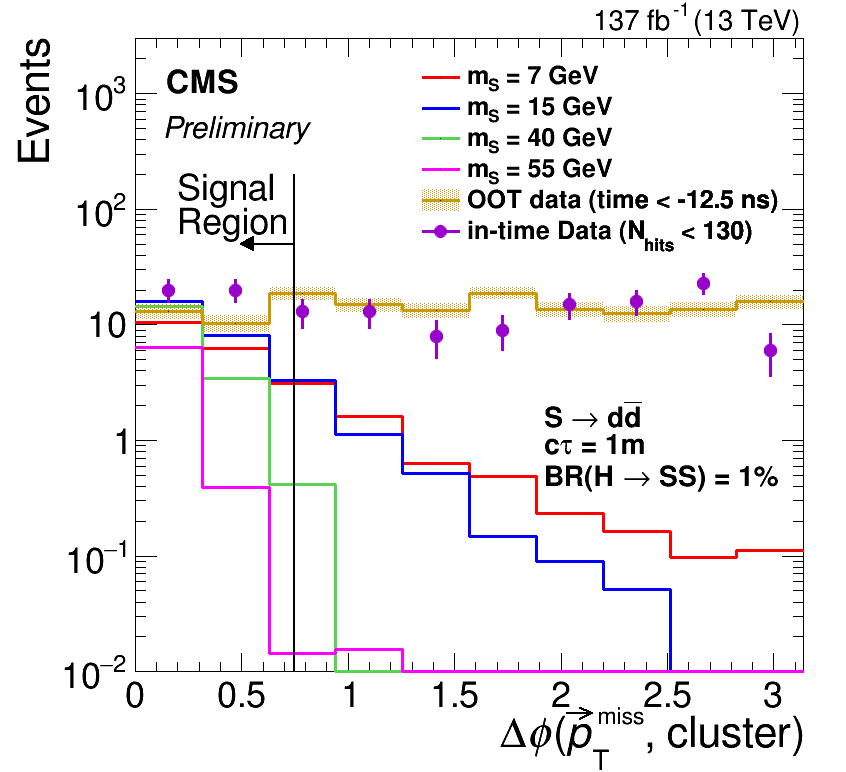

In [6]:

import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])
# from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle

corrections = 0.90332048232



index = 8
if index == 8:cut_index = 7
elif index == 7:cut_index = 8
with_background = 1
paper = 0
unblind = 0
nrechit_cut = 0
dphi_cut = 5



var = [leading_jet, me1112,re12,rb1,mb1,eta,time_spread, nCsc, dphiMet_cluster]
weights = [weight_jet, weight_me1112,weight_re12,weight_rb1,weight_mb1,weight_eta,weight_time_spread,weight, weight ]
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#phi(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster)']
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#it{#phi}(#vec{#it{p}}_{T}^{#scale[0.8]{ miss}}, cluster)']


name = ['leading_jet','me1112','re12','rb1','mb1','eta','time_spread','Nrechits','dphi_cluster_met']
ymax = 1090
# binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],[25,50,ymax],[10,0,3.14]]
binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],list(np.arange(50,1050+80,80)),[10,0,3.14]]


leg = rt.TLegend(0.49,0.68,0.74,0.92)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(masses):
    overflow = np.abs(var[index][k][cut_based_id[k]].flatten())
    if index == 7: overflow[overflow>=ymax]=ymax-1
#     h[k] = create_TH1D(overflow,  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
#                        weights = 0.01*weights[index][k][cut_based_id[k]].flatten())
    if cut_index == 7: h[k] = create_TH1D(overflow[var[cut_index][k][cut_based_id[k]].flatten()>=nrechit_cut],  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], var[cut_index][k]>=nrechit_cut)].flatten())
    else: h[k] = create_TH1D(overflow[np.abs(var[cut_index][k][cut_based_id[k]].flatten())<dphi_cut],  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                       weights = 0.01*weights[index][k][np.logical_and(cut_based_id[k], np.abs(var[cut_index][k])<dphi_cut)].flatten())
    h[k].SetLineColor(std_color_list[i+1])
    h[k].Scale(corrections)
    if index == 7: h[k].GetXaxis().SetNdivisions(5,5,0,False)
    h[k].SetLineWidth(3)
    leg.AddEntry(h[k],"m_{S} = "+k+" GeV")


cond = np.logical_and(nCsc['data_unblind']<130, cut_based_id['data_unblind'])
if cut_index == 7:
    h['data_oot'] = create_TH1D(np.abs(var[index]['data_oot'][np.logical_and(cut_based_id['data_oot'], var[cut_index]['data_oot']>=nrechit_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
    
    h['data_intime'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cond, var[cut_index]['data_unblind']>=nrechit_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])


else:
    h['data_oot'] = create_TH1D(np.abs(var[index]['data_oot'][np.logical_and(cut_based_id['data_oot'], np.abs(var[cut_index]['data_oot'])<dphi_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = [26,50,ymax])
    h['data_intime'] = create_TH1D(np.abs(var[index]['data_unblind'][np.logical_and(cond, np.abs(var[cut_index]['data_unblind'])<dphi_cut)].flatten()),  axis_title=[xaxis[index], 'Events'], binning = [26,50,ymax])

cond_oot = np.logical_and(nCsc['data_oot']<130, cut_based_id['data_oot'])

leg.AddEntry(h['data_oot'], 'OOT data (time < -12.5 ns)')

if index == 7:h['data_oot'].Scale(h['data_intime'].Integral()/np.count_nonzero(np.logical_and(cond_oot, np.abs(var[cut_index]['data_oot'])<dphi_cut)))
else:h['data_oot'].Scale(h['data_intime'].Integral()/np.count_nonzero(np.logical_and(cond_oot, var[cut_index]['data_oot']>=nrechit_cut)))
# h['data_oot'].Scale(h['data_intime'].Integral()/h['data_oot'].Integral())


    
# h['data_oot'].Scale(h['data_intime'].Integral()/h['data_oot'].Integral())




leg.AddEntry(h['data_intime'], 'in-time Data (N_{hits} < 130)')
h['data_intime'].SetLineColor(879)
h['data_intime'].SetLineWidth(3)
h['data_intime'].SetMarkerStyle(20)
h['data_intime'].SetMarkerSize(1.5)
h['data_intime'].SetMarkerColor(879)


# h['data_intime'].GetXaxis().SetLabelSize(0.04)
h['data_intime'].GetYaxis().SetRangeUser(0.01,3000)
h['data_intime'].Draw('esamex0')

h['data_oot'].SetLineColor(799)
h['data_oot'].SetLineWidth(3)

# h['data_oot'].Draw('E1 same')




# h['data_oot'].Draw('E1 same')

if index == 7:
    h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 2*max(map(lambda x: x.GetMaximum(), list(h.values()))))
else:
#     h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), max(map(lambda x: x.GetMaximum(), list(h.values()))))
    h[masses[0]].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 0.01*max(map(lambda x: x.GetMaximum(), list(h.values()))))


for k in masses:h[k].Draw(' hist same')
for k,v in h.items():print(k, v.Integral())




temp = h['data_oot'].Clone()
temp.Draw('hist same')

h['data_oot'].SetFillStyle(3002)
h['data_oot'].SetFillColor(h['data_oot'].GetLineColor())
h['data_oot'].SetLineColor(h['data_oot'].GetLineColor())
h['data_oot'].Draw('E2 same')

h['data_intime'].Draw('esamex0')

latex = rt.TLatex()
latex.SetTextSize(0.05)
latex.SetTextFont(42)
if index == 7:
    arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"|>")
    l = rt.TLine(130,0, 130, 50)
    arrow.SetLineWidth(2)        
    arrow.DrawArrow(130,20,200,20)
    latex.DrawLatex(140,28, "Signal Region")


else:
    if unblind:
        arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
        l = rt.TLine(0.75,0, 0.75, 50)
        arrow.SetLineWidth(2)        
        arrow.DrawArrow(0.5,15,0.75,15)
        latex.DrawLatex(0.2,30, "Signal")
        latex.DrawLatex(0.2,20, "Region")
    else:
        arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
        l = rt.TLine(0.75,0, 0.75, 200)
        arrow.SetLineWidth(2)        
        arrow.DrawArrow(0.5,50,0.75,50)
        latex.DrawLatex(0.2,120, "Signal")
        latex.DrawLatex(0.2,60, "Region")

latex = rt.TLatex()
latex.SetTextSize(0.04)
# if index == 8:
#     latex.DrawLatex(1.9,0.3, "BR(h^{0} #rightarrow SS) = 1%")
#     latex.DrawLatex(1.9,0.2, "c#tau = 1m")
# elif index == 7:
#     latex.DrawLatex(650,5, "BR(h^{0} #rightarrow SS) = 1%")
#     latex.DrawLatex(650,3, "c#tau = 1m")
    

if index == 8:
    x = 1.92
    if decay == 'dddd': latex.DrawLatex(x,1.3,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(x,1.3, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(x,1.3, "S #rightarrow #tau^{+}#tau^{-}")
    latex.DrawLatex(x,0.75, "c#tau = 1m")
    latex.DrawLatex(x,0.4, "BR(H #rightarrow SS) = 1%")
#     x = 1.94
#     if decay == 'dddd': latex.DrawLatex(x,0.46,  "S #rightarrow d#bar{d}")
#     elif decay == 'bbbb': latex.DrawLatex(x,0.6, "S #rightarrow b#bar{b}")
#     elif decay == '4Tau': latex.DrawLatex(x,0.6, "S #rightarrow #tau^{+}#tau^{-}")
#     latex.DrawLatex(x,0.27, "c#tau = 1m")
#     latex.DrawLatex(x,0.14, "BR(h^{0} #rightarrow SS) = 1%")

elif index == 7:
#     latex.DrawLatex(650,4.5, "c#tau = 1m")
#     latex.DrawLatex(650,8, "BR(h^{0} #rightarrow SS) = 1%")
#     if decay == 'dddd': latex.DrawLatex(650,15,  "S #rightarrow d#bar{d}")
#     elif decay == 'bbbb': latex.DrawLatex(650,15, "S #rightarrow b#bar{b}")
#     elif decay == '4Tau': latex.DrawLatex(650,15, "S #rightarrow #tau^{+}#tau^{-}")
    latex.DrawLatex(650,9, "c#tau = 1m")
    latex.DrawLatex(650,4.5, "BR(H #rightarrow SS) = 1%")
    if decay == 'dddd': latex.DrawLatex(650,15,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(650,15, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(650,15, "S #rightarrow #tau^{+}#tau^{-}")
        
        
# if index == 8:
    


# elif index == 7:
#     latex.DrawLatex(650,9, "c#tau = 1m")
#     latex.DrawLatex(650,4.5, "BR(h^{0} #rightarrow SS) = 1%")
#     if decay == 'dddd': latex.DrawLatex(650,15,  "S #rightarrow d#bar{d}")
#     elif decay == 'bbbb': latex.DrawLatex(650,15, "S #rightarrow b#bar{b}")
#     elif decay == '4Tau': latex.DrawLatex(650,15, "S #rightarrow #tau^{+}#tau^{-}")
l.SetLineWidth(2)
l.Draw()    


c.SetRightMargin(0.05)


tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Supplementary"
CMS_lumi.extraText   = "Preliminary"


CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.1
CMS_lumi.relPosY = 0.05

CMS_lumi.CMS_lumi(c, 4, 11)

c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()
outDir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version+'/unblind/'
if unblind:outDir += '/unblind/'
# if not paper:
# if CMS_lumi.writeExtraText:
#     c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_'+CMS_lumi.extraText+'.png')
#     c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_'+CMS_lumi.extraText+'.C')
#     c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux_'+CMS_lumi.extraText+'.pdf')
# else:
#     c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux.png')
#     c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux.C')
#     c.SaveAs(outDir+'/'+name[index]+'_'+decay+'_aux.pdf')


# dPhi plots

50 oot_vr
137 fb^{-1} (13 TeV)
here 0.25479999676346776
/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//test/
80 oot_vr
137 fb^{-1} (13 TeV)
here 0.25479999676346776
/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//test/
130 oot_vr
137 fb^{-1} (13 TeV)
here 0.25479999676346776
/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//test/


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//test//dphi_cluster_met_nRechit50_oot_vr_logy.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//test//dphi_cluster_met_nRechit50_oot_vr_logy.C has been generated
Info in <TCanvas::Print>: pdf file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//test//dphi_cluster_met_nRechit50_oot_vr_logy.pdf has been created
Warning in <TCanvas::Constru

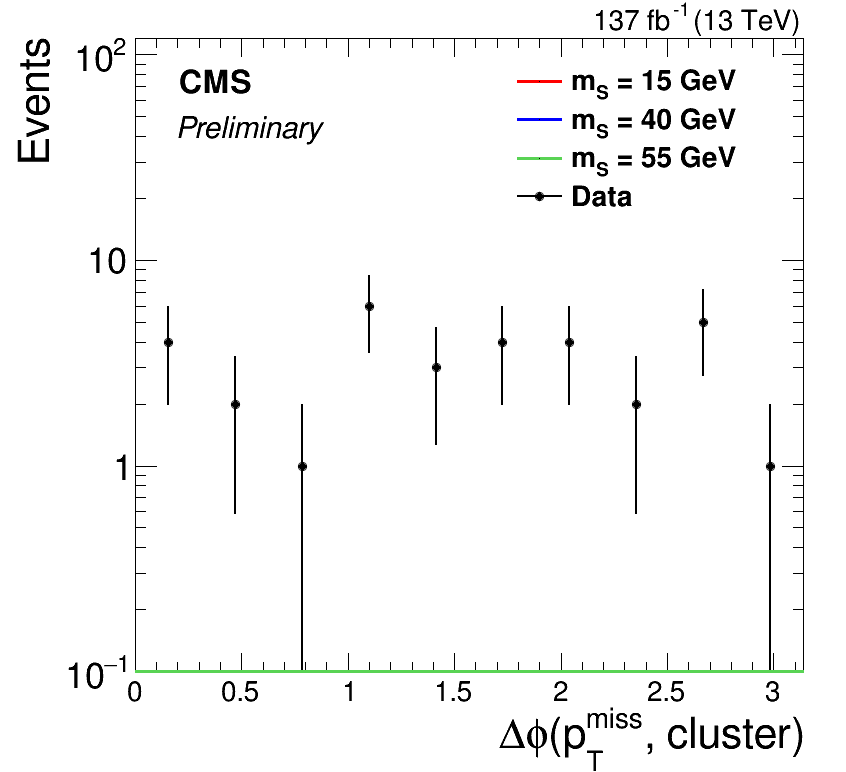

In [20]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])
# from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle

corrections = 0.90332048232



index = 8
with_background = 1
paper = 1
unblind = 1
var = [leading_jet, me1112,re12,rb1,mb1,eta,time_spread, nCsc, dphiMet_cluster]
weights = [weight_jet, weight_me1112,weight_re12,weight_rb1,weight_mb1,weight_eta,weight_time_spread,weight, weight ]
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]', 'N_{hits}', '#Delta#phi(p_{T}^{miss}, cluster)']
name = ['leading_jet','me1112','re12','rb1','mb1','eta','time_spread','Nrechits','dphi_cluster_met']
ymax = 1050
binning = [[50,0,500],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],[25,50,ymax],[10,0,3.14]]

# [30,0,3000]
# leg = rt.TLegend(0.35,0.72,0.78,0.92)


for cut in [50,80,130]:
    
    for k in ['SR', 'oot_vr', 'in-time_vr', 'in-time']:
#         if not (k == 'oot_vr' and cut ==80):continue
#         if not cut == 80:continue
        if not 'oot_vr' in k:continue
        print(cut, k)
        leg = rt.TLegend(0.60,0.72,0.90,0.92)
        leg.SetTextSize(0.04)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        c = rt.TCanvas('c','c', 850, 800)
        rt.gStyle.SetOptFit(1011)
        h = {}
        if not 'oot' in k: data_key = 'data_unblind'
        else: data_key = 'data_oot'
        cond = nCsc[data_key]>=cut
        if k == 'SR':
            cond = np.logical_and(cond, cut_based_id[data_key])
        elif 'vr' in k:
              cond = np.logical_and(cond, np.logical_not(cut_based_id[data_key]))
        h['data'] = create_TH1D(np.abs(dphiMet_cluster[data_key][cond].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])




        for i, m in enumerate(masses):
            if 'oot' in k: m = m+'_oot'
            cond = nCsc[m]>=cut
            if k == 'SR':
                cond = np.logical_and(cond, cut_based_id[m])
            elif 'vr' in k:
                cond = np.logical_and(cond, np.logical_not(cut_based_id[m]))
              
            h[m] = create_TH1D(dphiMet_cluster[m][cond].flatten(),  axis_title=[xaxis[index], 'Events'], binning = binning[index],\
                               weights = 0.01*weight[m][cond].flatten())
            h[m].SetLineColor(std_color_list[i+1])
            h[m].Scale(corrections)
            if index == 7: h[k].GetXaxis().SetNdivisions(5,5,0,False)
            h[m].SetLineWidth(3)
            leg.AddEntry(h[m],"m_{S} = "+m[:2]+" GeV")




        h['data'].SetLineColor(1)
        h['data'].SetMarkerStyle(20)
        h['data'].SetMarkerSize(1)
        h['data'].GetXaxis().SetLabelSize(0.04)
#         h['data'].GetYaxis().SetRangeUser(0.1,h['data'].Integral()/4)
#         h['data'].GetYaxis().SetRangeUser(0.1,h['data'].GetMaximum()*1.7)
        h['data'].GetYaxis().SetRangeUser(0.1,h['data'].GetMaximum()*20)

#         h['data'].GetYaxis().SetRangeUser(0.1,30)


#         h['data'].GetYaxis().SetRangeUser(0.1,1.7*max(map(lambda x: x.GetMaximum(), list(h.values()))))


        leg.AddEntry(h['data'], 'Data')
        h['data'].Draw('esamex0')


#         h['data'].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 2*max(map(lambda x: x.GetMaximum(), list(h.values()))))



        for m in masses:
            if 'oot' in k: m = m+'_oot'
            h[m].Draw(' hist same')




        c.SetRightMargin(0.05)


        CMS_lumi.cmsText     = "CMS"
        CMS_lumi.writeExtraText = True
        CMS_lumi.extraText   = "Preliminary"
        CMS_lumi.iPos=11
        CMS_lumi.relPosX = 0.12
        CMS_lumi.relPosY = 0.05

        CMS_lumi.CMS_lumi(c, 4, 11)

        c.SetLogy()
        leg.Draw()
        c.Draw()
        leg.Draw()
        outDir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version+'/test/'
        print(outDir)
        if not os.path.isdir(outDir):os.makedirs(outDir)
            

        c.SaveAs(outDir+'/'+name[index]+'_nRechit'+str(cut)+'_'+k+'_logy.png')
        c.SaveAs(outDir+'/'+name[index]+'_nRechit'+str(cut)+'_'+k+'_logy.C')
        c.SaveAs(outDir+'/'+name[index]+'_nRechit'+str(cut)+'_'+k+'_logy.pdf')

